In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.naive_bayes import GaussianNB, BernoulliNB

%matplotlib inline

In [2]:
demo = pd.read_csv('processed_data/weight-height-color.csv')

In [3]:
np.random.seed(52)

In [4]:
demo.head()

,Gender,Height,Weight,colorblind
0,Male,73.847017,241.893563,False
1,Male,68.781904,162.310473,True
2,Male,74.110105,212.740856,False
3,Male,71.730978,220.042470,False
4,Male,69.881796,206.349801,False


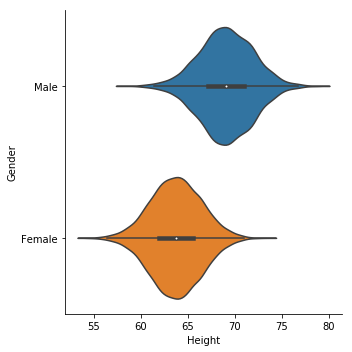

In [5]:
sns.catplot(x='Height', y='Gender', data=demo, kind='violin')

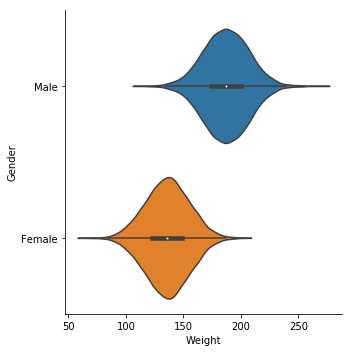

In [6]:
sns.catplot(x='Weight', y='Gender', data=demo, kind='violin');

In [7]:
percent_colorblind = {
    'Male': 0.08, 'Female': 0.005
}

In [8]:
def is_colorblind(row):
    return np.random.random() <= percent_colorblind[row['Gender']]

In [9]:
demo['colorblind'] = demo.apply(is_colorblind, axis=1)

In [10]:
demo.head()

,Gender,Height,Weight,colorblind
0,Male,73.847017,241.893563,False
1,Male,68.781904,162.310473,True
2,Male,74.110105,212.740856,False
3,Male,71.730978,220.042470,False
4,Male,69.881796,206.349801,False


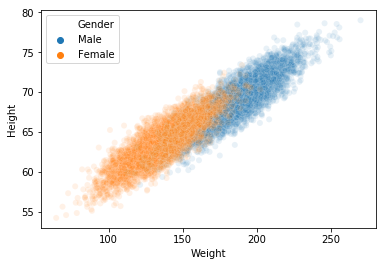

In [11]:
sns.scatterplot(x='Weight', y='Height', data=demo, hue='Gender',alpha=0.1);

In [12]:
X = demo.loc[:, 'Height':]
y = demo.Gender

In [13]:
feature_cnts = ['Height', 'Weight']
feature_cnts2 = ['Weight', 'Height']
feature_discrete=['colorblind']

In [14]:
clf_continous = GaussianNB().fit(X[feature_cnts], y)
y_predict = clf_continous.predict(X[feature_cnts])
clf_continous.score(X[feature_cnts], y)

0.8866

In [15]:
clf_continous = GaussianNB().fit(X[feature_cnts2], y)
y_predict = clf_continous.predict(X[feature_cnts2])
clf_continous.score(X[feature_cnts2], y)

0.8866

In [16]:
clf_discrete = BernoulliNB(alpha=0.0).fit(X[feature_discrete], y)
clf_discrete.score(X[feature_discrete], y)

/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/naive_bayes.py:480: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0.5385

## By hand?

Let's start by looking at weight:

In [17]:
demo.groupby('Gender').Weight.agg(['mean', 'std'])

,mean,std
Gender,,
Female,135.860093,19.022468
Male,187.020621,19.781155


We know that
$$P(c | W=w) = \frac{P(w|C=c)P(c)}{\text{evidence}} \propto P(w|C=c)P(c)$$

In [18]:
(y == 'Female').mean()

0.5

We have a 50/50 split of men and women

Therefore we have
$$P(\text{gender = female} | \text{weight}) = \frac{P(\text{weight | female})P(\text{female})}{P(\text{weight} | \text{female})P(\text{female}) + P(\text{weight} | \text{male})P(\text{male})}$$

In [19]:
just_weight = GaussianNB().fit(X.Weight.values.reshape(-1,1), y)

In [20]:
import inspect
print(inspect.getsource(GaussianNB))

class GaussianNB(BaseNB):
    """
    Gaussian Naive Bayes (GaussianNB)

    Can perform online updates to model parameters via `partial_fit` method.
    For details on algorithm used to update feature means and variance online,
    see Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque:

        http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf

    Read more in the :ref:`User Guide <gaussian_naive_bayes>`.

    Parameters
    ----------
    priors : array-like, shape (n_classes,)
        Prior probabilities of the classes. If specified the priors are not
        adjusted according to the data.

    var_smoothing : float, optional (default=1e-9)
        Portion of the largest variance of all features that is added to
        variances for calculation stability.

    Attributes
    ----------
    class_prior_ : array, shape (n_classes,)
        probability of each class.

    class_count_ : array, shape (n_classes,)
        number of training samples 

In [21]:
demo_weight_summary = demo.groupby('Gender').Weight.agg(['mean', 'std'])
demo_height_summary = demo.groupby('Gender').Height.agg(['mean', 'std'])

In [22]:
demo_weight_summary

,mean,std
Gender,,
Female,135.860093,19.022468
Male,187.020621,19.781155


In [23]:
demo_weight_summary.loc['Female', 'mean']

135.8600930074687

In [24]:
def prob_female_by_weight(w):
    z_female = (w - demo_weight_summary.loc['Female', 'mean']) / demo_weight_summary.loc['Female', 'std']
    z_male = (w - demo_weight_summary.loc['Male', 'mean']) / demo_weight_summary.loc['Male', 'std']
    
    liklihood_f = np.exp(-z_female**2/2)/demo_weight_summary.loc['Female', 'std']
    liklihood_m = np.exp(-z_male**2/2)/demo_weight_summary.loc['Male', 'std']
    
    return liklihood_f/(liklihood_f + liklihood_m)

In [25]:
prob_female_by_weight(45)

0.9999994454376446

In [26]:
just_weight.predict_proba([[45], [20], [120]])[:, 0]

array([0.99999945, 0.99999996, 0.99564575])

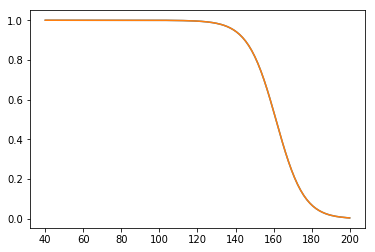

In [27]:
W = np.linspace(40, 200, 200)
our_model = np.array([prob_female_by_weight(w) for w in W])
sklearn_model = just_weight.predict_proba(W.reshape(-1,1))[:, 0]

plt.plot(W, our_model)
plt.plot(W, sklearn_model)

In [28]:
max(abs(our_model - sklearn_model))

4.588337324520908e-05

## Make a height based model

In [29]:
def prob_female_by_height(w):
    z_female = (w - demo_height_summary.loc['Female', 'mean']) / demo_height_summary.loc['Female', 'std']
    z_male = (w - demo_height_summary.loc['Male', 'mean']) / demo_height_summary.loc['Male', 'std']
    
    liklihood_f = np.exp(-z_female**2/2)/demo_height_summary.loc['Female', 'std']
    liklihood_m = np.exp(-z_male**2/2)/demo_height_summary.loc['Male', 'std']
    
    return liklihood_f/(liklihood_f + liklihood_m)

In [30]:
prob_female_by_height(75)

0.0014538335537605854

In [31]:
just_height = GaussianNB().fit(X.Height.values.reshape(-1,1), y)

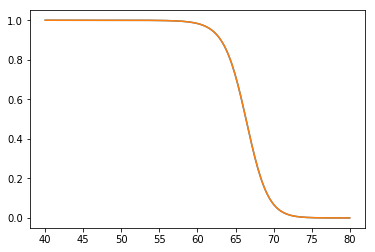

In [32]:
H = np.linspace(40, 80, 200)
our_model_h = np.array([prob_female_by_height(h) for h in H])
sklearn_model_w = just_height.predict_proba(H.reshape(-1,1))[:, 0]

plt.plot(H, our_model_h)
plt.plot(H, sklearn_model_w)

## Do both

In [33]:
def prob_female(w, h):
    contrib_female = prob_female_by_weight(w)*prob_female_by_height(h)
    contrib_male = (1-prob_female_by_weight(w))*(1 - prob_female_by_height(h))
    return contrib_female/(contrib_female + contrib_male)

In [34]:
prob_female(140,55), prob_female(160, 65)

(0.9999376362970102, 0.7504374571905227)

In [35]:
clf_continous.predict_proba([[140,55], [160,65]])[:, 0]

array([0.99993776, 0.75047496])

# Colorblindness

In [36]:
colorblindness_rates = demo.groupby('Gender').colorblind.mean()
colorblindness_rates

Gender
Female    0.0056
Male      0.0826
Name: colorblind, dtype: float64

We now have
$$
P(\text{female}|\text{colorblind}) = \frac{P(\text{colorblind}|\text{female})P(\text{female})}{P(\text{colorblind}|\text{female})P(\text{female}) + P(\text{colorblind}|\text{male})P(\text{male})}
$$


In [37]:
def get_prob_female_by_colorblindness(is_colorblind):
    prop_female = 0.5
    prop_male = 1 - prop_female
    if is_colorblind:
        rates = colorblindness_rates
    else:
        rates = 1 - colorblindness_rates
    return rates['Female']*prop_female / (rates['Female']*prop_female + rates['Male']*prop_male)

In [38]:
get_prob_female_by_colorblindness(False), get_prob_female_by_colorblindness(True) 

(0.5201380897583429, 0.06349206349206349)

In [39]:
1 / ((colorblindness_rates['Male'])/(colorblindness_rates['Female']) + 1)

0.06349206349206349

In [40]:
(colorblindness_rates['Male'])/(colorblindness_rates['Female'])


14.750000000000002

In [41]:
1/15.75

0.06349206349206349

In [42]:
clf_discrete.predict_proba([[True], [False]])

array([[0.06349206, 0.93650794],
       [0.52013809, 0.47986191]])

## Now use the feature union!

In [43]:
from sklearn.pipeline import FeatureUnion

f_union = FeatureUnion()

TypeError: __init__() missing 1 required positional argument: 'transformer_list'